In [47]:
from keras.models import Sequential, load_model
from keras.layers import Dense
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sn

import numpy as np
import pandas as pd

# Load dataset

In [48]:
# load dataset
dataset = np.loadtxt('Train.csv', delimiter=',', skiprows=1)

# training and validation set
X_train = dataset[:140000,:60]
# X_train = dataset[:, :4]
# y_train = dataset[:, 4:]
y_train = dataset[:140000, 60:]

# testing set
X_test = dataset[140001:, :60]
y_test = dataset[140001:, 60:]

# Pre-training Phase

In [3]:
# sigmoid activation function
def sigmoid(x, derivative=False):
    if derivative:
        return x * (1 - x)

    return 1.0 / (1 + np.exp(-x))

In [9]:
# RBM

# initial weight for rbm
def init_rbm(num_visible, num_hidden):
    np_rng = np.random.RandomState(1234)

    weights = np.asarray(np_rng.uniform(
        low=-0.1 * np.sqrt(6. / (num_hidden + num_visible)),
        high=0.1 * np.sqrt(6. / (num_hidden + num_visible)),
        size=(num_visible, num_hidden)))

    # Insert weights for the bias units into the first row and first column.
    weights = np.insert(weights, 0, 0, axis=0)
    weights = np.insert(weights, 0, 0, axis=1)

    return weights


# train rbm
def train_rbm(dataset, num_visible, num_hidden, dbn_N, max_epoch=100, learning_rate=0.1, batch_size=30):
    """

    :param dataset: training dataset
    :param num_visible: input size (visible unit)
    :param num_hidden: hidden unit size
    :param dbn_N: rbm number of dbn
    :param max_epoch: total epoch number 
    :param learning_rate: learning rate
    :batch_size: batch size of training data
    :return: list of weights of each rbm
    """
    
    # Insert bias units of 1 into the first column.
    dataset = np.insert(dataset, 0, 1, axis=1)
    weights = init_rbm(num_visible, num_hidden)
    for epoch in range(max_epoch):
        reconstructed_data = list()

        # creating mini batch 
        for i in range(0, dataset.shape[0], batch_size):
            train_data = dataset[i:i + batch_size]
            num_examples = train_data.shape[0]

            # (This is the "positive CD phase", aka the reality phase.)
            pos_hidden_activations = np.dot(train_data, weights)
            pos_hidden_probs = sigmoid(pos_hidden_activations)
            pos_hidden_probs[:, 0] = 1
            pos_hidden_states = pos_hidden_probs > np.random.rand(num_examples, num_hidden + 1)
            pos_associations = np.dot(train_data.T, pos_hidden_probs)

            # (This is the "negative CD phase", aka the daydreaming phase.)
            neg_visible_activations = np.dot(pos_hidden_states, weights.T)
            neg_visible_probs = sigmoid(neg_visible_activations)
            neg_visible_probs[:, 0] = 1

            neg_hidden_activations = np.dot(neg_visible_probs, weights)
            neg_hidden_probs = sigmoid(neg_hidden_activations)

            # adding batch data in reconstructed_data list to pass to next RBM layer
            reconstructed_data[i:i + 30] = neg_hidden_probs

            neg_hidden_probs[:, 0] = 1

            neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

            # Update weights.
            weights += learning_rate * ((pos_associations - neg_associations) / num_examples)

            error = np.sum((train_data - neg_visible_probs) ** 2)
        if True:
            print(">>RBM[{}] Epoch {}: error is {}".format(dbn_N, epoch, error))
    # print("Epoch %s: error is %s" % (epoch, error))

    return weights, reconstructed_data


In [5]:
# DBN

def train_dbn(X):
    """

    :param X: dataset
    :param visible_layer: input size (visible unit)
    :return: list of weights of each rbm
    """

    # layer: number of layers eg. [5, 10, 1] represent 2 rbm i.e, 3 layers(total) with 5, 10, and 1 node respectively
    layer = [X.shape[1], 300, 100, 100]

    rbm_1 = train_rbm(dataset=X, num_visible=layer[0], num_hidden=layer[1], dbn_N=1)
    # delete first bias column
    X = np.delete(rbm_1[1], 0, 1)  # after training value of hidden units in 1st rbm becomes input unit for next rbm
    rbm_1 = np.delete(rbm_1[0], 0, 0)  # delete bias -> first row
    rbm_1 = np.delete(rbm_1, 0, 1)  # delete bias -> first column

    rbm_2 = train_rbm(dataset=X, num_visible=layer[1], num_hidden=layer[2], dbn_N=2)
    # delete first bias column
    X = np.delete(rbm_2[1], 0, 1)  # after training value of hidden units in 1st rbm becomes input unit for next rbm
    rbm_2 = np.delete(rbm_2[0], 0, 0)  # delete bias -> first row
    rbm_2 = np.delete(rbm_2, 0, 1)  # delete bias -> first column

    rbm_3 = train_rbm(dataset=X, num_visible=layer[2], num_hidden=layer[3], dbn_N=3)
    # delete first bias column
    X = np.delete(rbm_3[1], 0, 1)  # after training value of hidden units in 1st rbm becomes input unit for next rbm
    rbm_3 = np.delete(rbm_3[0], 0, 0)  # delete bias -> first row
    rbm_3 = np.delete(rbm_3, 0, 1)  # delete bias -> first column

#     rbm_4 = train_rbm(dataset=X, num_visible=layer[3], num_hidden=layer[4], dbn_N=4)
#     rbm_4 = np.delete(rbm_4[0], 0, 0)  # delete bias -> first row
#     rbm_4 = np.delete(rbm_4, 0, 1)  # delete bias -> first column

    weights = list()
    weights.append(rbm_1)
    weights.append(rbm_2)
    weights.append(rbm_3)
#     weights.append(rbm_4)

    print("\t\t\n\n[INFO] Pre-Training completed\n\n")

    return weights

In [10]:
# pretraining with dbn
dbn_model = train_dbn(X_train)

>>RBM[1] Epoch 0: error is 9.085994395240165
>>RBM[1] Epoch 1: error is 8.067053908788653
>>RBM[1] Epoch 2: error is 6.806649062962345
>>RBM[1] Epoch 3: error is 8.178484177015607
>>RBM[1] Epoch 4: error is 5.6136845937382525
>>RBM[1] Epoch 5: error is 8.141331765705598
>>RBM[1] Epoch 6: error is 8.829436125819276
>>RBM[1] Epoch 7: error is 5.8371952472708095
>>RBM[1] Epoch 8: error is 6.471514127616966
>>RBM[1] Epoch 9: error is 6.695790189523803
>>RBM[1] Epoch 10: error is 5.059712292296879
>>RBM[1] Epoch 11: error is 4.653203582061469
>>RBM[1] Epoch 12: error is 3.934169982178952
>>RBM[1] Epoch 13: error is 5.177656799857657
>>RBM[1] Epoch 14: error is 6.6447305698462245
>>RBM[1] Epoch 15: error is 5.503499985360692
>>RBM[1] Epoch 16: error is 4.2556394615262825
>>RBM[1] Epoch 17: error is 4.082954771114515
>>RBM[1] Epoch 18: error is 4.4802685865566785
>>RBM[1] Epoch 19: error is 6.224672716243047
>>RBM[1] Epoch 20: error is 5.311879873959399
>>RBM[1] Epoch 21: error is 3.663858344

>>RBM[2] Epoch 79: error is 4.142934539141255
>>RBM[2] Epoch 80: error is 5.573902790533312
>>RBM[2] Epoch 81: error is 2.8217728576948717
>>RBM[2] Epoch 82: error is 4.973863076710867
>>RBM[2] Epoch 83: error is 5.23680258875328
>>RBM[2] Epoch 84: error is 4.2612966484532535
>>RBM[2] Epoch 85: error is 6.733914067827426
>>RBM[2] Epoch 86: error is 9.996222995477444
>>RBM[2] Epoch 87: error is 5.704245617608198
>>RBM[2] Epoch 88: error is 8.865905243660514
>>RBM[2] Epoch 89: error is 3.770441197879889
>>RBM[2] Epoch 90: error is 5.150826392926415
>>RBM[2] Epoch 91: error is 5.7736181342774735
>>RBM[2] Epoch 92: error is 3.4763228628342033
>>RBM[2] Epoch 93: error is 5.098813217366585
>>RBM[2] Epoch 94: error is 4.525886139705854
>>RBM[2] Epoch 95: error is 7.176897896676058
>>RBM[2] Epoch 96: error is 3.4531697939548947
>>RBM[2] Epoch 97: error is 6.800653666248168
>>RBM[2] Epoch 98: error is 5.504846117327184
>>RBM[2] Epoch 99: error is 5.070195078850125
>>RBM[3] Epoch 0: error is 6.6

# Fine-tuning Phase

In [ ]:
dbn_model

In [11]:
# finetuning 

def build_model(weight):
    model = Sequential()
    model.add(Dense(300, input_dim=60, activation='sigmoid'))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(100, activation='sigmoid'))
#     model.add(Dense(40, activation='sigmoid'))
    model.add(Dense(12, activation='softmax'))
    
    # setup input and first hidden layer with pretrained weight
    bias = np.random.rand(300)
    model.layers[0].set_weights([weight[0], bias])
    bias = np.random.rand(100)
    model.layers[1].set_weights([weight[1], bias])
    model.layers[2].set_weights([weight[2], bias])
#     model.layers[3].set_weights([weight[3], bias])
    
    return model

In [18]:
model = build_model(dbn_model)
# compile built model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
clf = model.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=10)

Epoch 1/50
9380/9380 [==============================] - 14s 1ms/step - loss: 0.5768 - accuracy: 0.7344 - val_loss: 0.4646 - val_accuracy: 0.7747
Epoch 2/50
9380/9380 [==============================] - 14s 1ms/step - loss: 0.4504 - accuracy: 0.7833 - val_loss: 0.4545 - val_accuracy: 0.7876
Epoch 3/50
9380/9380 [==============================] - 14s 2ms/step - loss: 0.4292 - accuracy: 0.7917 - val_loss: 0.4564 - val_accuracy: 0.7934
Epoch 4/50
9380/9380 [==============================] - 16s 2ms/step - loss: 0.4183 - accuracy: 0.7955 - val_loss: 0.4132 - val_accuracy: 0.7989
Epoch 5/50
9380/9380 [==============================] - 22s 2ms/step - loss: 0.4093 - accuracy: 0.8000 - val_loss: 0.3921 - val_accuracy: 0.8089
Epoch 6/50
9380/9380 [==============================] - 22s 2ms/step - loss: 0.4017 - accuracy: 0.8022 - val_loss: 0.3995 - val_accuracy: 0.8017
Epoch 7/50
9380/9380 [==============================] - 21s 2ms/step - loss: 0.3957 - accuracy: 0.8039 - val_loss: 0.3819 - val_ac

In [14]:
# save trained model
model.save('ddos_model')

INFO:tensorflow:Assets written to: ddos_model/assets


In [ ]:
# summary of architecture

model.summary()

# Plot Accuracy and Loss Graph

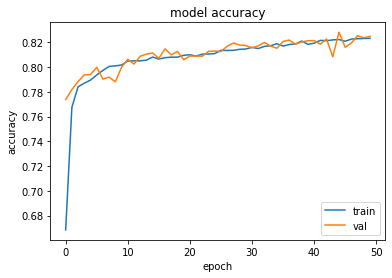

In [15]:
# summarize history for accuracy
plt.plot(clf.history['accuracy'])
plt.plot(clf.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.savefig('model_accuracy_1.jpg')
plt.show()

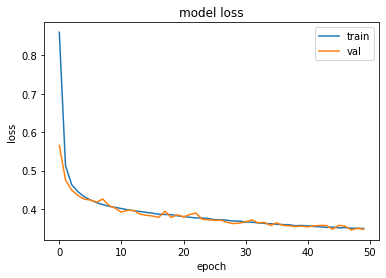

In [16]:
# summarize history for loss
plt.plot(clf.history['loss'])
plt.plot(clf.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('model_loss_1.jpg')
plt.show()

# Evaluation

In [49]:
# load trained model

model = load_model('ddos_model')

In [50]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [51]:
y_test = np.argmax(y_test, axis=1)

In [52]:
label = ["BENIGN","DNS","LDAP","MSSQL","NTP","NetBIOS","SNMP","SSDP","UDP","Syn","TFTP","UDPLag"]

In [53]:
# confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

In [54]:
df_cm = pd.DataFrame(confusion_matrix, columns=label, index=label)

In [55]:
df_cm.head()

,BENIGN,DNS,LDAP,MSSQL,NTP,NetBIOS,SNMP,SSDP,UDP,Syn,TFTP,UDPLag
BENIGN,2942,0,0,0,5,0,0,0,0,0,0,0
DNS,4,581,2,10,30,5,2,41,0,0,0,1
LDAP,0,2,29,459,0,0,0,216,0,0,0,0
MSSQL,0,4,19,481,0,1,0,220,0,0,0,0
NTP,45,56,0,0,582,0,0,0,0,0,0,0


Text(69.0, 0.5, 'True Label')

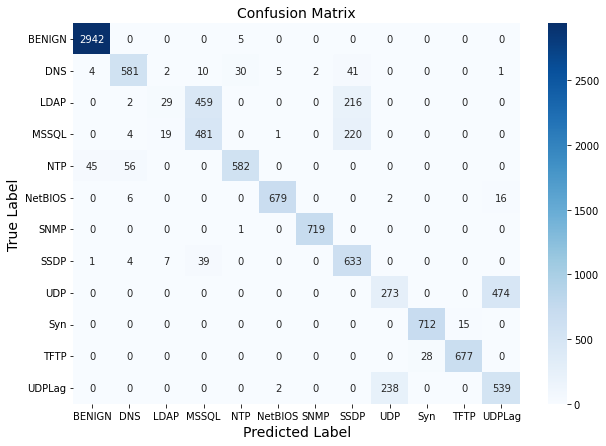

In [62]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues", fmt="g")
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)


In [63]:
# classification report

label = ["BENIGN","DNS","LDAP","MSSQL","NTP","NetBIOS","SNMP","SSDP","UDP","Syn","TFTP","UDPLag"]
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=label))


Classification Report

              precision    recall  f1-score   support

      BENIGN       0.98      1.00      0.99      2947
         DNS       0.89      0.86      0.87       676
        LDAP       0.51      0.04      0.08       706
       MSSQL       0.49      0.66      0.56       725
         NTP       0.94      0.85      0.89       683
     NetBIOS       0.99      0.97      0.98       703
        SNMP       1.00      1.00      1.00       720
        SSDP       0.57      0.93      0.71       684
         UDP       0.53      0.37      0.43       747
         Syn       0.96      0.98      0.97       727
        TFTP       0.98      0.96      0.97       705
      UDPLag       0.52      0.69      0.60       779

    accuracy                           0.82     10802
   macro avg       0.78      0.78      0.75     10802
weighted avg       0.82      0.82      0.80     10802

